In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from tqdm import tqdm
from math import *
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def davies_harte(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=np.complex); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=np.complex)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path


def fBm(MC,N,H):
    '''
    Generates many samples of paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        MC:     number of samples
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    B = [davies_harte(1, N, H) for i in tqdm(range(MC))]
    B = np.real(np.array(B))
    return B


def drift(x,m, nature, dim):
    '''
    Generates an approximation of the drift evaluated on the array x
    
    args:
        x:      array
        m:      order of the approximation (high m = better approximation)
        nature: type of drift (dirac, indicator function,...)
        dim:    dimension
    '''

    if nature == 'void':
        return 0
    if nature == 'reg':
        return -x
    if nature == 'ind':
        return norm.cdf(x,0,1/m)
    if nature == 'dirac':
        return sqrt(m/(2*pi)) * np.exp(-(x**2) * m /2)

    
    
def Sde(size, true_size, approx, B, nature, dim, MC=1):
    '''
    Simulates the SDE via a Euler scheme
    
    args:
        time_step
        true_step: step used for the true solution
        approx:    order of approximation of the drift
        B:         fBm
        nature:    nature of the drift
        dim:       dimension
        MC:        Monte-Carlo size
    '''
    time_step = 1/size
    step = int(true_size/size)
    s = np.zeros((MC,size+1))
    for i in range(0,size):
        s[:,i+1] = s[:,i] + time_step*drift(s[:,i],approx,nature,dim) + (B[:,(i+1)*step]-B[:,i*step])
    return s



def error(true_size, size_list, nature, scaling, H, dim, MC):
    inf_h = 1/true_size
    B = fBm(MC,true_size,H) 
    inf_m = true_size**(scaling)
    
    #Simulation of the true SDE
    true_sde = Sde(true_size,true_size,inf_m,B,nature,dim, MC)
    
    error=[]
    #sd= []
    for size in size_list:
        h = 1/size
        m = size**(scaling)
        index = np.linspace(0,true_size,size+1)
        index = [ int(index[i]) for i in range(size+1)] 
        true_sde_interpol = true_sde[:, index]
        #Simulation of SDE with time step h
        h_sde = Sde(size, true_size, m, B, nature, dim, MC)
        Ech = h_sde-true_sde_interpol
        S = np.mean(Ech, axis=0)
        incr = [(S[i+1]-S[i])**2 for i in range(len(S)-1)]
        incr = np.array(incr)*(size)
        res = np.max(incr)
        print(res)
        error.append(res)
    return error



#Fixing the parameters


true_size = 1000000 #time-step for true solution
MC= 10 #Monte-Carlo 
H = 0.4 #Hurst parameter
#hlist = [0.1]
size_list = [100, 500, 1000, 5000, 10000, 50000] #list of time steps
nature = 'ind' #drift
scaling = 1
dim = 1 #dimension

#Running an example
MC2 = 10
e = np.zeros((MC2,len(size_list)))
for i in tqdm(range(MC2)):
    e[i,:] = error(true_size,size_list,nature, scaling, H,dim,MC)

100%|██████████| 10/10 [01:37<00:00,  9.77s/it]


0.0003438771281114177
5.336642831880376e-05
3.6557440001022056e-05
8.77805000011143e-06
5.569600000145298e-06


  0%|          | 0/10 [00:00<?, ?it/s]

1.2500000000673354e-06



100%|██████████| 10/10 [01:41<00:00, 10.16s/it]


0.0004926573975377811
0.00011981801438655531
4.8207327973567366e-05
6.408200000227196e-06
4.622500000017108e-06


  0%|          | 0/10 [00:00<?, ?it/s]

1.0124999999965609e-06



100%|██████████| 10/10 [01:36<00:00,  9.69s/it]


0.00034930793688305045
0.00011529599737348174
5.225796001765688e-05
8.528450016013158e-06
3.9203999999982074e-06


  0%|          | 0/10 [00:00<?, ?it/s]

8.820000000002612e-07



100%|██████████| 10/10 [01:35<00:00,  9.57s/it]


0.00019266853505483164
9.772616105637876e-05
3.81415210110938e-05
7.182050001160648e-06
5.034738734693963e-06


  0%|          | 0/10 [00:00<?, ?it/s]

1.8605000000008178e-06



100%|██████████| 10/10 [01:35<00:00,  9.60s/it]


0.0002410018873287789
6.133700525017371e-05
4.227136000018898e-05
1.1424200000227001e-05
4.120900000095575e-06


  0%|          | 0/10 [00:00<?, ?it/s]

9.679999999770917e-07



100%|██████████| 10/10 [01:36<00:00,  9.64s/it]


0.0004360396982511434
6.885770681023142e-05
2.927530388171556e-05
6.444050000205821e-06
2.6569000002481492e-06


  0%|          | 0/10 [00:00<?, ?it/s]

8.000000000023808e-07



100%|██████████| 10/10 [01:36<00:00,  9.66s/it]


0.00017203807127079694
6.948984968230584e-05
3.4079595064745516e-05
1.0974796908650794e-05
5.736213542348702e-06


  0%|          | 0/10 [00:00<?, ?it/s]

6.844999999980154e-07



100%|██████████| 10/10 [01:36<00:00,  9.70s/it]


0.0004220296672289119
6.635700559047539e-05
3.0348272126571885e-05
5.814049999991313e-06
6.1062671721593085e-06


  0%|          | 0/10 [00:00<?, ?it/s]

6.845000000032945e-07



100%|██████████| 10/10 [01:37<00:00,  9.75s/it]


0.00018006418466345135
4.660244915844068e-05
4.494399841449416e-05
1.0857800000525421e-05
4.928400000020256e-06


  0%|          | 0/10 [00:00<?, ?it/s]

9.680000000023938e-07



100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


0.00044361407239391774
8.763930834086078e-05
3.239999999962841e-05
1.0718450000026938e-05
3.8025000000129626e-06


100%|██████████| 10/10 [25:07<00:00, 150.77s/it]

6.480000002008243e-07


[3.27329858e-04 7.86489926e-05 3.88482778e-05 8.71300969e-06
 4.64984194e-06 9.75800000e-07]
[1.15666267e-04 2.40403858e-05 7.41786148e-06 2.05753673e-06
 9.93755069e-07 3.42960143e-07]


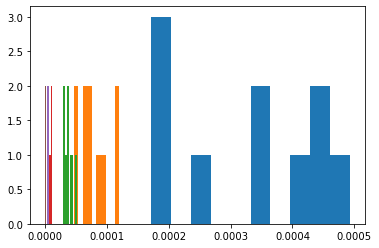

In [2]:
for i in range(len(size_list)):
    plt.hist(e[:,i])
print(np.mean(e, axis=0))
print(np.sqrt(np.var(e, axis=0)))

[0.46844805]


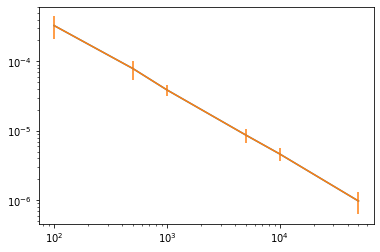

In [3]:
res = np.mean(e, axis=0)
err = np.sqrt(np.var(e, axis=0))
plt.loglog(size_list,res)
plt.errorbar(size_list, res, yerr= err)
reg = LinearRegression().fit(np.log(np.array(size_list)).reshape(-1,1), np.log(np.array(res)).reshape(-1,1))
print(-reg.coef_[0]/2)